<a href="https://colab.research.google.com/github/nimnathw/energy-consumption/blob/main/energy_consumption_short_form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### I use a time-series dataset from the UCI database. The target is the energy consmuption of a single house. The features set includes weather data and household sensor data collected over time. Domain specific knowledge implies that there is unlikely to be temporal trends. However, I check for stationarity as well as auto-correlation, heteroskedasticity and multicollinatarity.

In [29]:
# Import libraries

import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

file = '/content/drive/MyDrive/Colab Notebooks/energydata_complete.csv'

df = pd.read_csv(file)
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [30]:
# Show the list of columns
print(df.columns)

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')


In [31]:
# Convert string to datetime object
df['date'] = pd.to_datetime(df['date'])

# Set index
df.set_index('date', inplace=True)

# Print the processed dataframe
print(df)

                     Appliances  lights         T1       RH_1         T2  \
date                                                                       
2016-01-11 17:00:00          60      30  19.890000  47.596667  19.200000   
2016-01-11 17:10:00          60      30  19.890000  46.693333  19.200000   
2016-01-11 17:20:00          50      30  19.890000  46.300000  19.200000   
2016-01-11 17:30:00          50      40  19.890000  46.066667  19.200000   
2016-01-11 17:40:00          60      40  19.890000  46.333333  19.200000   
...                         ...     ...        ...        ...        ...   
2016-05-27 17:20:00         100       0  25.566667  46.560000  25.890000   
2016-05-27 17:30:00          90       0  25.500000  46.500000  25.754000   
2016-05-27 17:40:00         270      10  25.500000  46.596667  25.628571   
2016-05-27 17:50:00         420      10  25.500000  46.990000  25.414000   
2016-05-27 18:00:00         430      10  25.500000  46.600000  25.264286   

           

In [32]:
# Check for missing values
print(df.isnull().sum(axis=0)) # count missing values for each column


Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


In [33]:
# Check for data types of columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

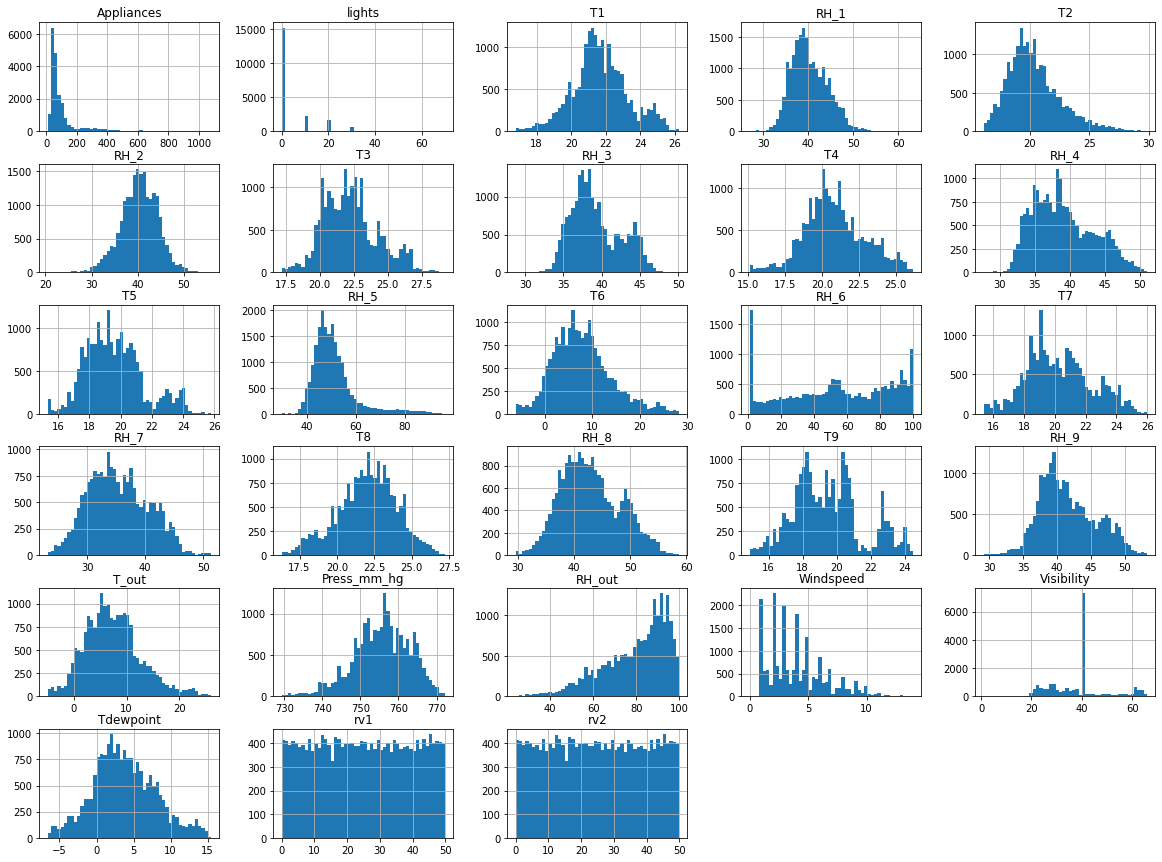

In [34]:
# Visualize the distribution of data
df.hist(bins=50, figsize=(20, 15))
plt.show()

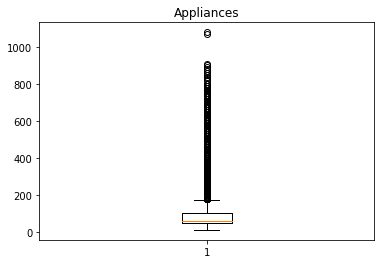

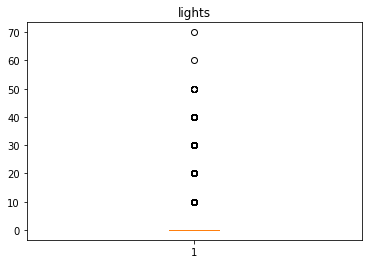

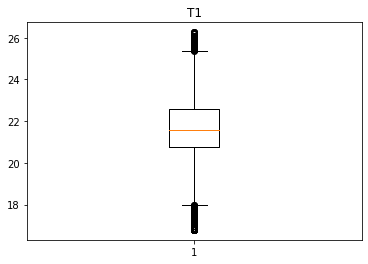

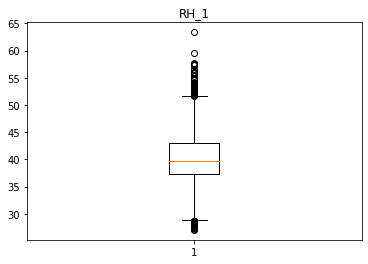

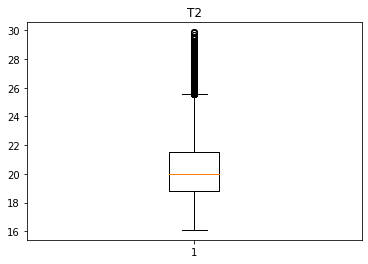

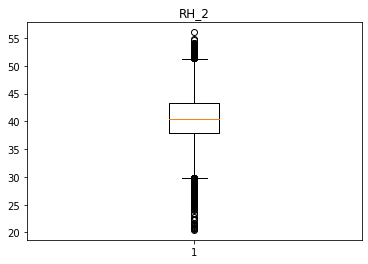

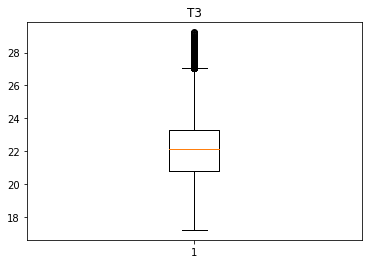

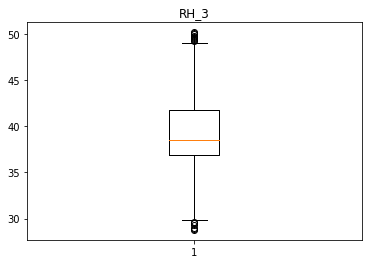

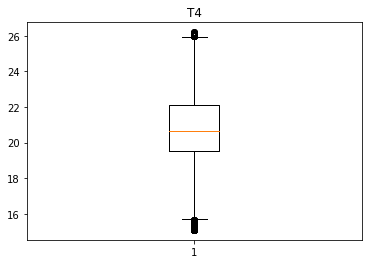

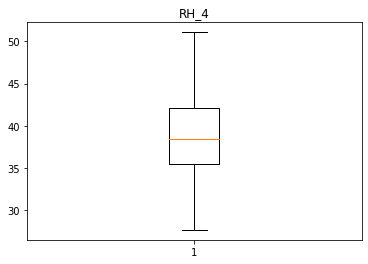

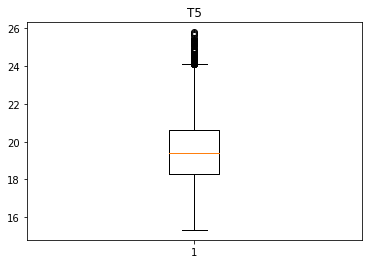

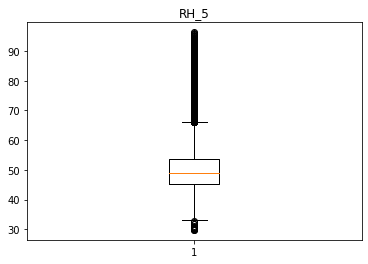

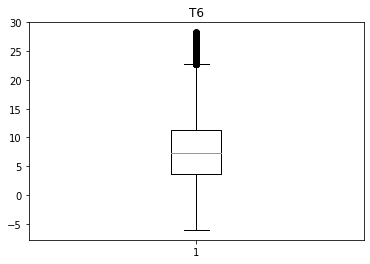

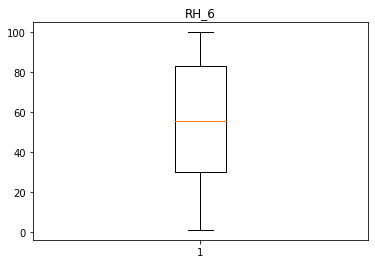

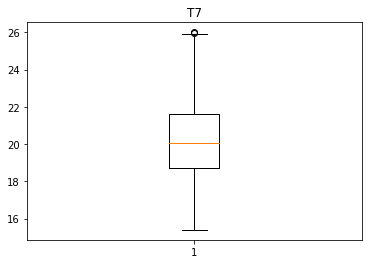

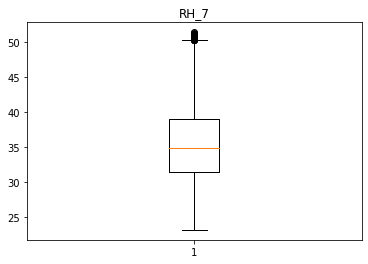

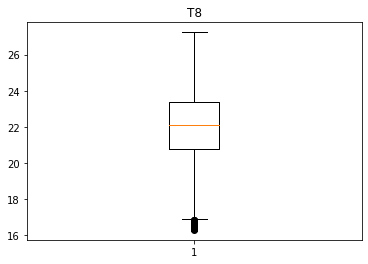

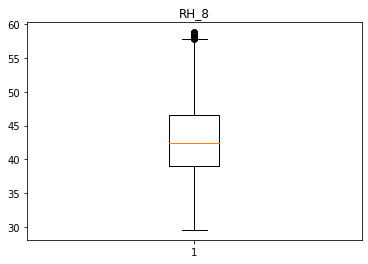

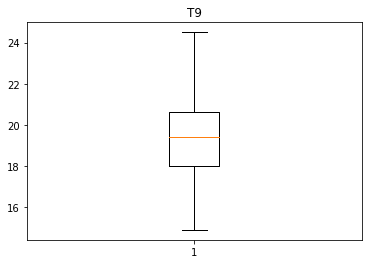

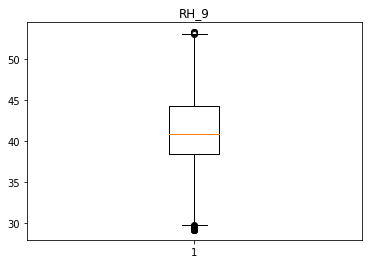

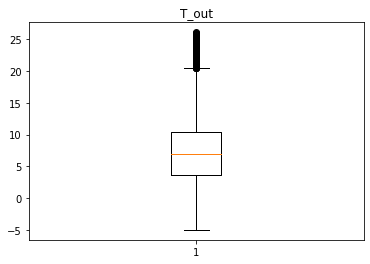

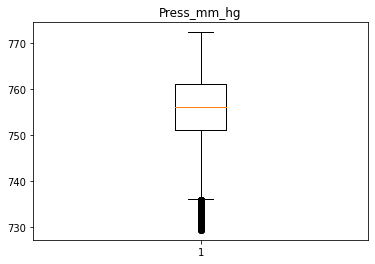

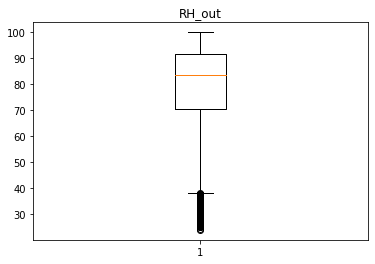

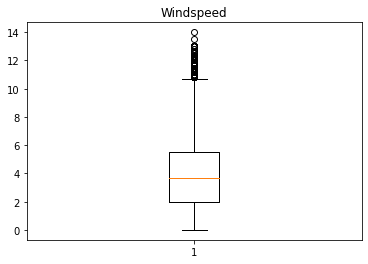

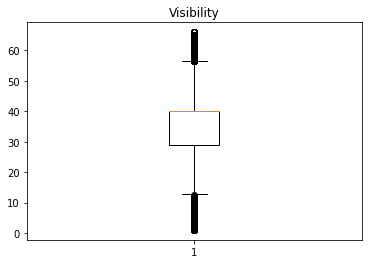

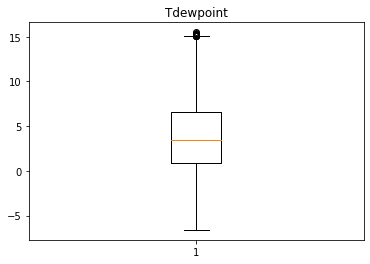

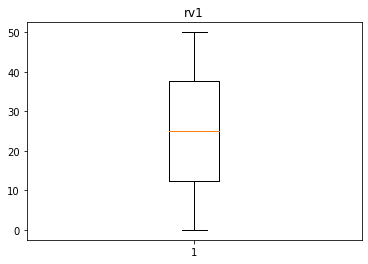

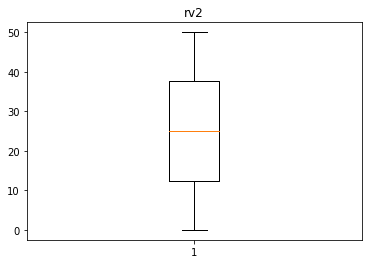

In [35]:
# Check for outliers of data
# create a boxplot for each column of the DataFrame
for column in df.columns:
    plt.boxplot(df[column])
    plt.title(column)
    plt.show()

In [36]:
# Calculate z-score for each data point
df_zscore = df.apply(stats.zscore)

# Remove rows with z-score of more than 5 in any column
df_filtered = df[(df_zscore < 5).all(axis=1)]

print(df_filtered.count())

Appliances     19583
lights         19583
T1             19583
RH_1           19583
T2             19583
RH_2           19583
T3             19583
RH_3           19583
T4             19583
RH_4           19583
T5             19583
RH_5           19583
T6             19583
RH_6           19583
T7             19583
RH_7           19583
T8             19583
RH_8           19583
T9             19583
RH_9           19583
T_out          19583
Press_mm_hg    19583
RH_out         19583
Windspeed      19583
Visibility     19583
Tdewpoint      19583
rv1            19583
rv2            19583
dtype: int64


In [37]:
# Identify potential outliers by fitting a linear regression line with the target
# Define the threshold for outlier detection
threshold = 2.5

# Loop over all columns (features) except the target
for column in df_filtered.columns:
   
    # Fit a linear regression model for the current feature and the target
    X = df_filtered[column].values.reshape(-1, 1)
    y = df_filtered['Appliances'].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    
    # Compute the predicted target values and the residuals
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # Compute the absolute residuals and the standard deviation
    abs_resid = np.abs(residuals)
    std_resid = np.std(residuals)
    
    # Identify the outliers based on the threshold and remove them
    mask = abs_resid > threshold * std_resid
    df_filtered = df_filtered[~mask]

df_filtered.count()


Appliances     15028
lights         15028
T1             15028
RH_1           15028
T2             15028
RH_2           15028
T3             15028
RH_3           15028
T4             15028
RH_4           15028
T5             15028
RH_5           15028
T6             15028
RH_6           15028
T7             15028
RH_7           15028
T8             15028
RH_8           15028
T9             15028
RH_9           15028
T_out          15028
Press_mm_hg    15028
RH_out         15028
Windspeed      15028
Visibility     15028
Tdewpoint      15028
rv1            15028
rv2            15028
dtype: int64

* Removing observations based on scatter deltes a large number of observations.
* Therefore, we will **NOT** remove the observations.

In [38]:
# Calculate z-score for each data point
df_zscore = df.apply(stats.zscore)

# Remove rows with z-score of more than 5 in any column
df_filtered = df[(df_zscore < 5).all(axis=1)]

print(df_filtered.count())

Appliances     19583
lights         19583
T1             19583
RH_1           19583
T2             19583
RH_2           19583
T3             19583
RH_3           19583
T4             19583
RH_4           19583
T5             19583
RH_5           19583
T6             19583
RH_6           19583
T7             19583
RH_7           19583
T8             19583
RH_8           19583
T9             19583
RH_9           19583
T_out          19583
Press_mm_hg    19583
RH_out         19583
Windspeed      19583
Visibility     19583
Tdewpoint      19583
rv1            19583
rv2            19583
dtype: int64


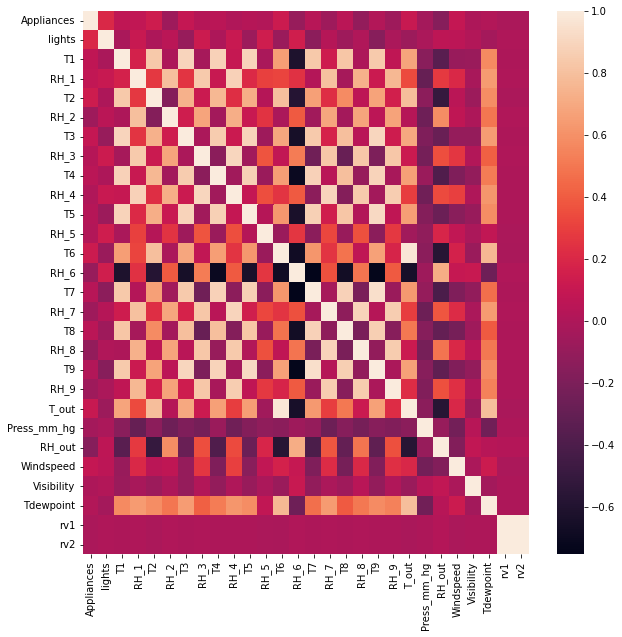

In [39]:
# Visualize correlation between variables
# Set up larger figure
fig, ax = plt.subplots(figsize=(10,10))

# Visualize correlation between variables after one-hot encoding
corr = df_filtered.corr()
sns.heatmap(corr, annot=False, ax=ax)

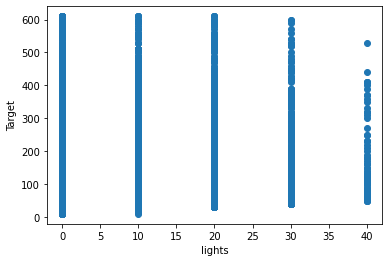

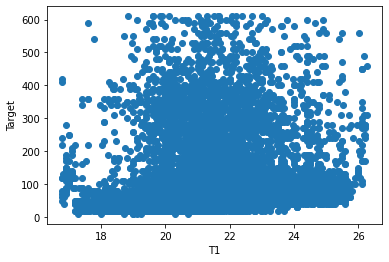

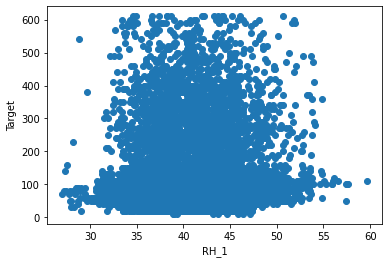

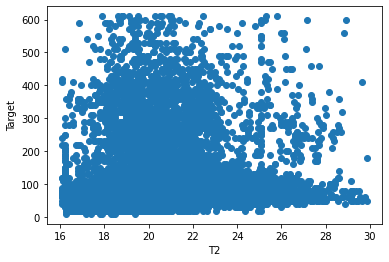

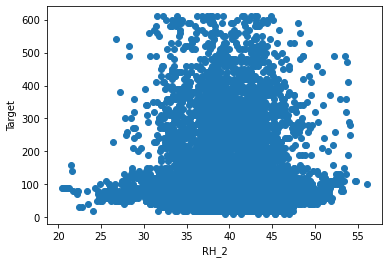

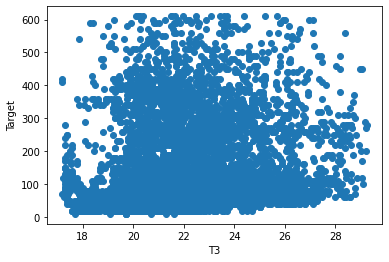

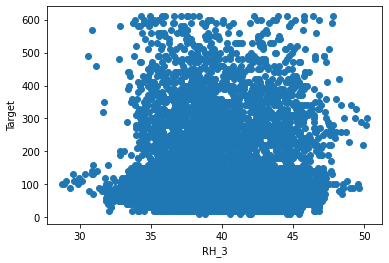

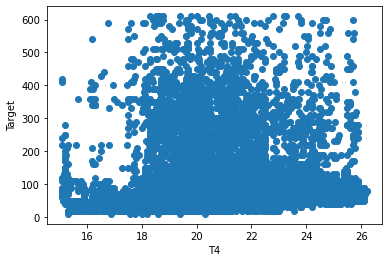

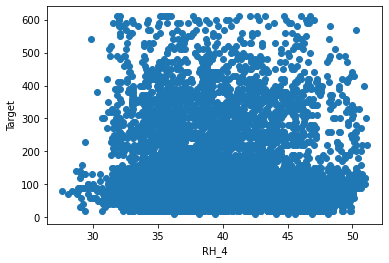

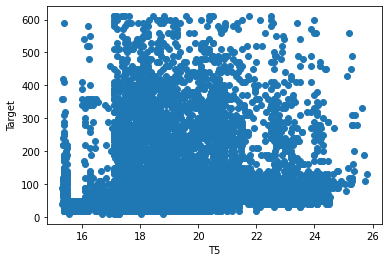

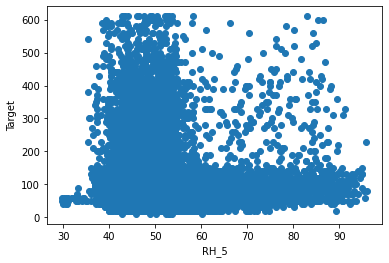

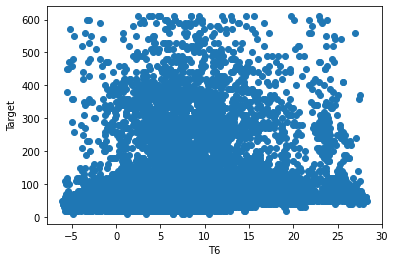

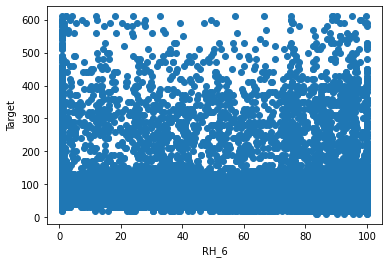

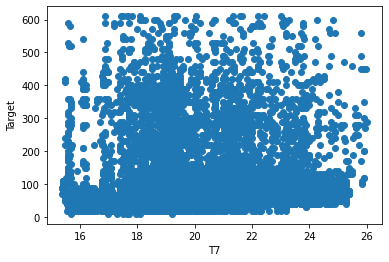

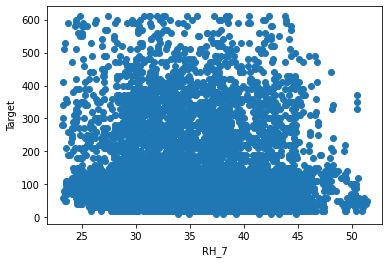

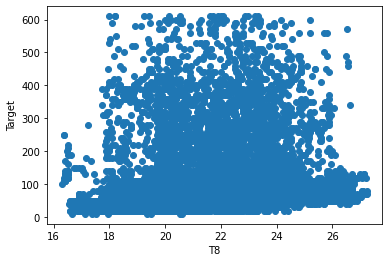

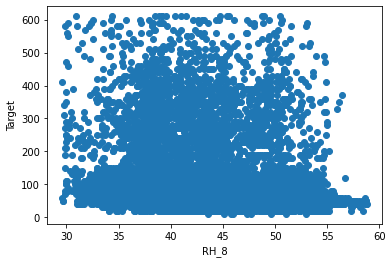

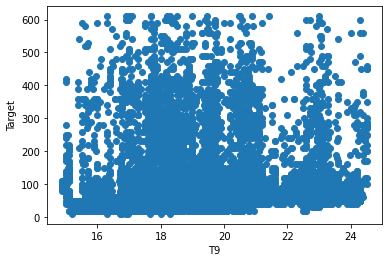

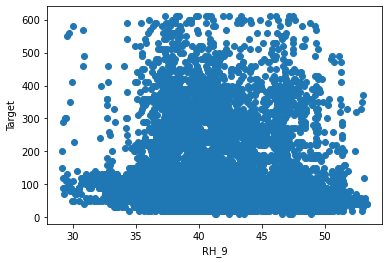

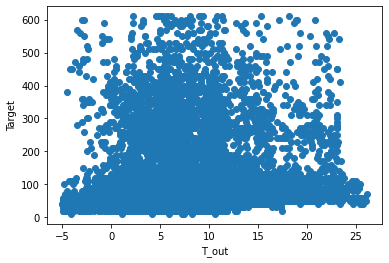

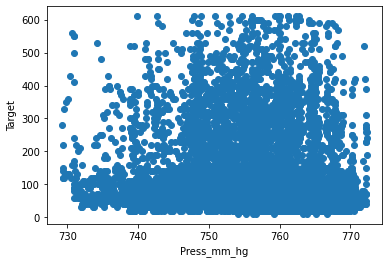

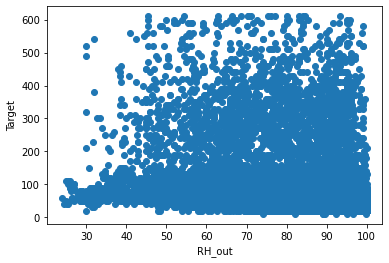

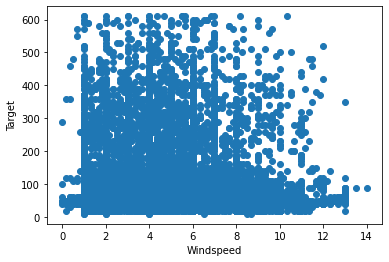

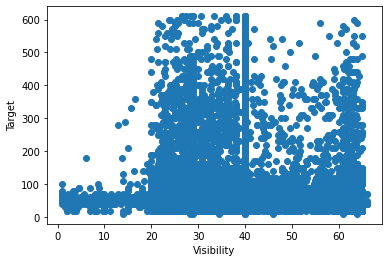

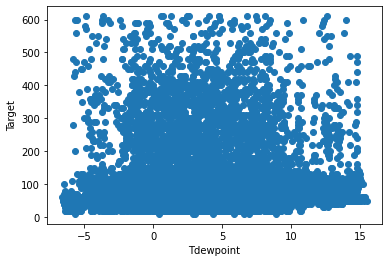

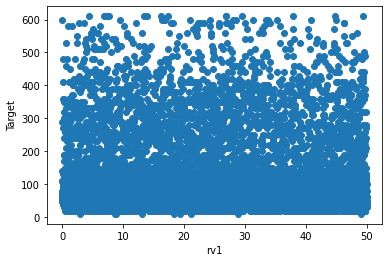

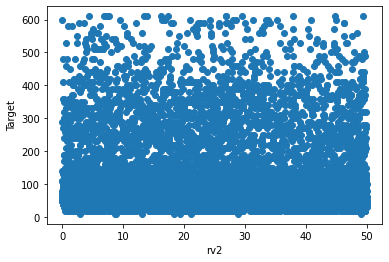

In [40]:
# Create X features set and y outcome set
X = df_filtered.drop(["Appliances"], axis=1)
y = df_filtered["Appliances"]

for feature in X.columns:
    plt.scatter(X[feature], y)
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

In [41]:
# Calculate VIF for each feature to identify multicollinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# Show VIF values
print(vif)

     VIF Factor     features
0      1.578723       lights
1   3633.770535           T1
2   1704.079282         RH_1
3   2526.721341           T2
4   2206.983759         RH_2
5   1249.989252           T3
6   1574.221438         RH_3
7   1030.998978           T4
8   1397.200496         RH_4
9   1188.482310           T5
10    45.185704         RH_5
11    88.731264           T6
12    40.542203         RH_6
13  1615.993207           T7
14   518.140860         RH_7
15   988.705956           T8
16   581.384170         RH_8
17  2603.989388           T9
18   640.804548         RH_9
19   398.628229        T_out
20  2083.799021  Press_mm_hg
21  1297.529169       RH_out
22     5.252546    Windspeed
23    12.001561   Visibility
24   132.215214    Tdewpoint
25          inf          rv1
26          inf          rv2


/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


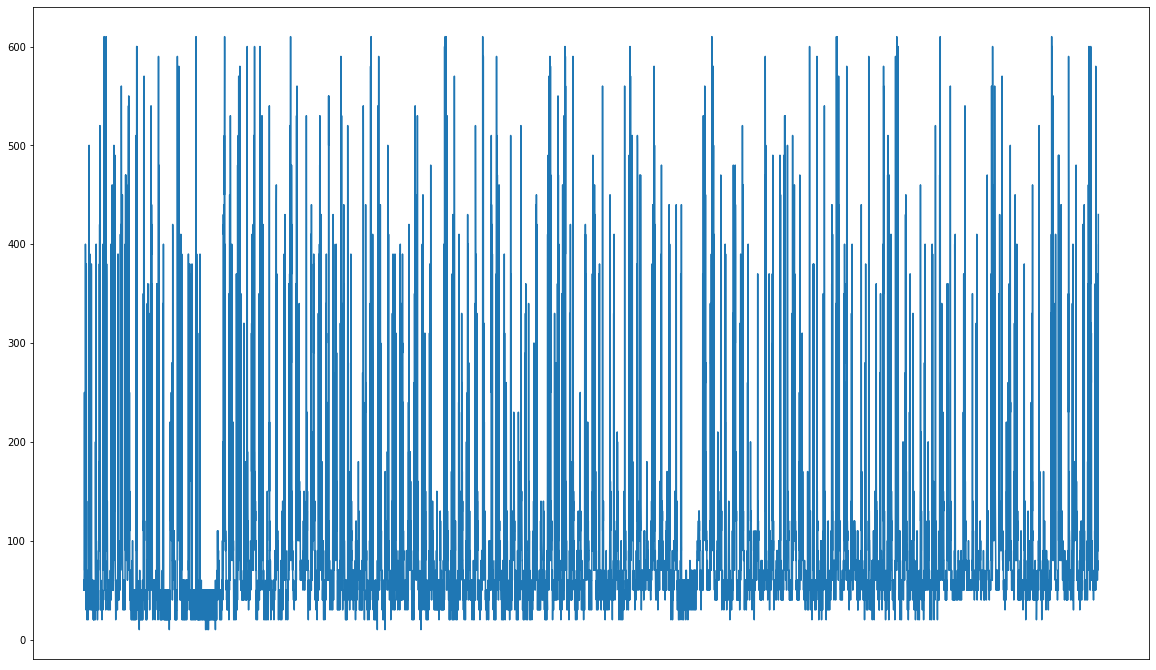

ADF Statistic: -20.52810094387668
p-value: 0.0
The time series is stationary.


In [42]:
# Check for stationarity
# Create X features set and y outcome set
X = df_filtered.drop(["Appliances"], axis=1)
y = df_filtered["Appliances"]

# Adjust the figsize
fig, ax = plt.subplots(figsize=(20, 12)) 

# set x-tick labels horizontally
plt.xticks([])  # Set the x-axis labels to an empty list
plt.plot(y)
plt.show()

# Augmented Dickey-Fuller (ADF) test or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
# Perform ADF test on the time series
result = adfuller(df_filtered["Appliances"])

# Print the test statistic and p-value
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpret the results
if result[1] > 0.05:
    print("The time series is not stationary.")
else:
    print("The time series is stationary.")



In [43]:
# Check for auto-correlation
# Extract the dependent variable (temporal y data) from the dataframe
y = df_filtered["Appliances"]

# Perform Durbin-Watson test for first-order autocorrelation
dw_test = sm.stats.stattools.durbin_watson(y)

# Print the test statistic and conclusion
print("Durbin-Watson test statistic:", dw_test)
if dw_test < 1.5:
    print("Positive autocorrelation present.")
elif dw_test > 2.5:
    print("Negative autocorrelation present.")
else:
    print("No significant autocorrelation detected.")

Durbin-Watson test statistic: 0.25179197492980204
Positive autocorrelation present.


Mean squared error:  6405.458800732713
Root mean squared error:  80.03411023265463
R-squared:  0.17203301553844175


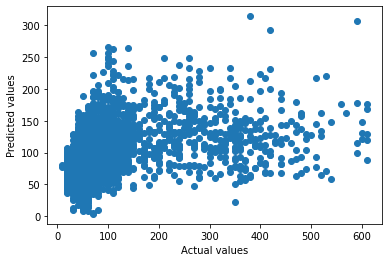

Autocorrelation detected
Heteroskedasticity detected
WLS statistics
Mean squared error:  6591.605290494876
Root mean squared error:  81.18870174165168
R-squared:  0.14797179641408298
WLS model


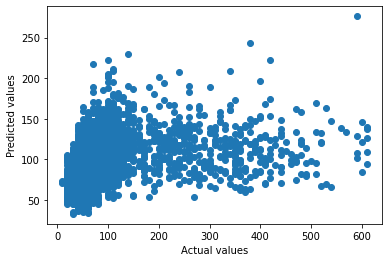

In [44]:
# Run an OLS model after a regular train_test_split

# Create X features set and y outcome set
X = df_filtered.drop(["Appliances"], axis=1)
y = df_filtered["Appliances"]

# Set a random seed for reproducibility
np.random.seed(123)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Initialize the model     
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Predict y values for the validation set
y_pred = lr.predict(X_val)

# Calculate model perfomance metrics for the validation set
# Calculate mean squared error
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

# Calculate R-squared score
r2 = r2_score(y_val, y_pred)
print("R-squared: ", r2)

# Plot predicted values  against the actual values for the validation set
plt.scatter(y_val, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

# Calculate statistics for model robustness
# Test for autocorrelation
acf = sm.tsa.stattools.acf(residuals, nlags=20, fft=False)
if np.abs(acf[1:]).max() > 0.5:
    print('Autocorrelation detected')

# Run Weighted Least Squares if heteroskedasticity is detected
# Test for heteroskedasticity (Breusch Pagan()
residuals = y_val - y_pred
_, p, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals, X_val)

if p < 0.05:
    print('Heteroskedasticity detected')

    # Calculate residuals and fitted values for the validation set
    residuals = y_val - lr.predict(X_val)
    fitted_values = lr.predict(X_val)

    # Create DataFrame with residuals and fitted values
    df_residuals = pd.DataFrame({'residuals': residuals, 'fitted_values': fitted_values})

    # Estimate variance function of errors
    ols_residuals = sm.OLS(residuals.abs(), fitted_values).fit()
    var_func = ols_residuals.fittedvalues**2

    # Calculate weight vector
    wt = 1 / var_func

    # Fit WLS model
    wls = sm.WLS(endog=y_val, exog=X_val, weights=wt).fit()

    # Predict y values for the validation set
    y_pred_WLS = wls.predict(X_val)

    # Print WLS model statistics
    print("WLS statistics")

    # Calculate mean squared error
    mse_WLS = mean_squared_error(y_val, y_pred_WLS)
    print("Mean squared error: ", mse_WLS)

    # Calculate root mean squared error
    rmse_WLS = np.sqrt(mse_WLS)
    print("Root mean squared error: ", rmse_WLS)

    # Calculate R-squared score
    r2_WLS = r2_score(y_val, y_pred_WLS)
    print("R-squared: ", r2_WLS)

    # Plot predicted values  against the actual values for the validation set
    print("WLS model")
    plt.scatter(y_val, y_pred_WLS)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.show()


In [45]:
# Run a model with lagged variables include in X (to counter auto-correlation)
# Create lagged versions of the dependent variable and any relevant predictors
df_filtered["Appliances_1"] = df_filtered["Appliances"].shift(1)
df_filtered["Appliances_2"] = df_filtered["Appliances"].shift(2)
df_filtered['Windspeed_1'] = df_filtered['Windspeed'].shift(1)
df_filtered['Windspeed_2'] = df_filtered['Windspeed'].shift(2)

# Drop any rows with missing values
df_filtered = df.dropna()

# Extract the dependent variable (temporal y data) and predictors from the dataframe
y = df_filtered["Appliances"]
X = df_filtered.drop(["Appliances"], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit a linear regression model with lagged predictors
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Appliances   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     149.7
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        09:25:47   Log-Likelihood:            -1.1760e+05
No. Observations:               19735   AIC:                         2.353e+05
Df Residuals:                   19708   BIC:                         2.355e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          50.2084     94.593      0.531      

<ipython-input-45-5f21d65fdc91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Appliances_1"] = df_filtered["Appliances"].shift(1)
<ipython-input-45-5f21d65fdc91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Appliances_2"] = df_filtered["Appliances"].shift(2)
<ipython-input-45-5f21d65fdc91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [46]:
# Calculate z-score for each data point
df_zscore = df.apply(stats.zscore)

# Remove rows with z-score of more than 5 in any column
df_filtered = df[(df_zscore < 5).all(axis=1)]

print(df_filtered.count())

Appliances     19583
lights         19583
T1             19583
RH_1           19583
T2             19583
RH_2           19583
T3             19583
RH_3           19583
T4             19583
RH_4           19583
T5             19583
RH_5           19583
T6             19583
RH_6           19583
T7             19583
RH_7           19583
T8             19583
RH_8           19583
T9             19583
RH_9           19583
T_out          19583
Press_mm_hg    19583
RH_out         19583
Windspeed      19583
Visibility     19583
Tdewpoint      19583
rv1            19583
rv2            19583
dtype: int64


Lasso Regression Summary:
Intercept:  -71.33740493633519
Coefficients:  [ 1.61962345e+00  0.00000000e+00  1.28100661e+01 -1.46368865e+01
 -1.12339209e+01  2.25451993e+01  4.89891794e+00 -3.92426674e+00
  4.84268517e-02  1.10041190e+00  1.03097901e-01  5.96295515e+00
  3.21241653e-01 -1.04694916e-01 -1.47952631e+00  7.44699792e+00
 -4.73811992e+00 -1.25920439e+01 -1.37619495e+00 -5.90670454e+00
  1.83292780e-01 -3.66624288e-01  1.83611562e+00  1.30510770e-01
  1.77753771e+00  5.25385003e-02  3.50213896e-18]
Training R^2:  0.17499778133878863
Validation R^2:  0.1719085652876513
Training MSE:  6471.089587054968
Validation MSE:  6406.421593898551

Ridge Regression Summary:
Intercept:  -55.82990257241795
Coefficients:  [  1.60829225   1.03420393  13.16881917 -16.08268985 -11.86109894
  22.67718279   5.05584137  -3.95688611   0.08165366   1.67346007
   0.09465899   6.35846023   0.33642736  -0.29673517  -1.45539703
   7.64667823  -4.77936521 -12.91615825  -1.35174526  -7.25741669
   0.1928782

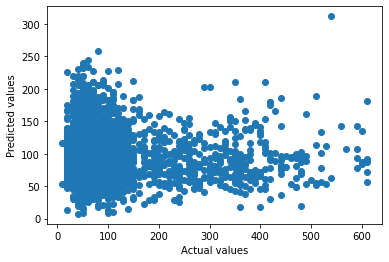


 Ridge Regression Model


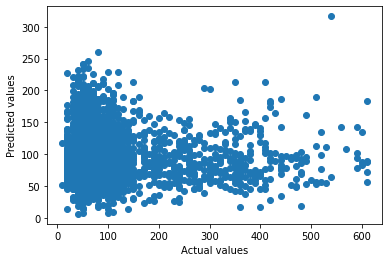

In [47]:
# Run Lasso Regression and Ridge Regression ( to counter multi-collinearity)

# Create X features set and y outcome set
X = df_filtered.drop(["Appliances"], axis=1)
y = df_filtered["Appliances"]

# Set a random seed for reproducibility
np.random.seed(123)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X2_train, X_val, y2_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Create Lasso or Ridge model
alpha = 0.1 # regularization parameter
lasso_model = Lasso(alpha=alpha)
ridge_model = Ridge(alpha=alpha)

# Train model to train set
lasso_model.fit(X2_train, y2_train)
ridge_model.fit(X2_train, y2_train)

# Print out model summary
print("Lasso Regression Summary:")
print("Intercept: ", lasso_model.intercept_)
print("Coefficients: ", lasso_model.coef_)
print("Training R^2: ", lasso_model.score(X_train, y_train))
print("Validation R^2: ", lasso_model.score(X_val, y_val))
print("Training MSE: ", mean_squared_error(y_train, lasso_model.predict(X_train)))
print("Validation MSE: ", mean_squared_error(y_val, lasso_model.predict(X_val)))

print("\nRidge Regression Summary:")
print("Intercept: ", ridge_model.intercept_)
print("Coefficients: ", ridge_model.coef_)
print("Training R^2: ", ridge_model.score(X_train, y_train))
print("Validation R^2: ", ridge_model.score(X_val, y_val))
print("Training MSE: ", mean_squared_error(y_train, ridge_model.predict(X_train)))
print("Validation MSE: ", mean_squared_error(y_val, ridge_model.predict(X_val)))

# Make predictions
lasso_preds = lasso_model.predict(X_test)
ridge_preds = ridge_model.predict(X_test)

# Plot predicted values against the actual values for the validation set
print("\n Lasso Regression Model")
plt.scatter(y_val, lasso_preds)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

# Plot predicted values against the actual values for the validation set
print("\n Ridge Regression Model")
plt.scatter(y_val, ridge_preds)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()



Mean squared error:  6502.380385802693
Root mean squared error:  80.63733865773779
R-squared:  0.0810577423195461


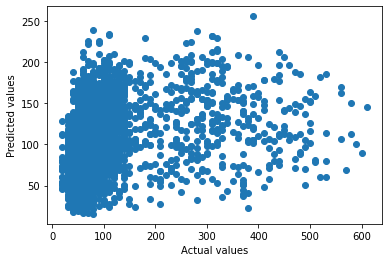

In [48]:
# Run an OLS model after TimeSeriesSplit

# Create X features set and y outcome set
X = df_filtered.drop(["Appliances"], axis=1)
y = df_filtered["Appliances"]

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert numpy array back to pandas dataframe
X = pd.DataFrame(data=X, columns= df_filtered.drop(["Appliances"], axis=1).columns)

# Set a random seed for reproducibility
np.random.seed(123)

# Split the data into train and test sets using TimeSeriesSplit
tss1 = TimeSeriesSplit(n_splits=2, test_size=int(len(X) * 0.3))

for train_index, test_index in tss1.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Reset the indices of X and y
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Split the train set into train and validation sets using TimeSeriesSplit
tss2 = TimeSeriesSplit(n_splits=2, test_size=int(len(X_train) * 0.3))

for train_index, val_index in tss2.split(X_train):
    X2_train, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index,:]
    y2_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

# Initialize the model     
lr = LinearRegression()

# Train the model
lr.fit(X2_train, y2_train)

# Predict y values for the validation set
y_pred = lr.predict(X_val)

# Calculate model perfomance metrics for the validation set
# Calculate mean squared error
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

# Calculate R-squared score
r2 = r2_score(y_val, y_pred)
print("R-squared: ", r2)

# Plot predicted values  against the actual values for the validation set
plt.scatter(y_val, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

In [49]:
# Re-run a model with PCA (to counter multi-collinearity)

# Create X features set and y outcome set
X = df_filtered.drop(["Appliances"], axis=1)
y = df_filtered["Appliances"]

# Perform PCA with 5 components
pca = PCA(n_components=5)
pca.fit(X)

# Get the transformed data
X = pca.transform(X)

# Print the variance explained by each component
print("Variance explained by principal components: ", pca.explained_variance_ratio_)

# Convert numpy array back to pandas dataframe
X = pd.DataFrame(data=X)

# Set a random seed for reproducibility
np.random.seed(123)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Initialize the model     
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Predict y values for the validation set
y_pred = lr.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

# Calculate R-squared score
r2 = r2_score(y_val, y_pred)
print("R-squared: ", r2)


Variance explained by principal components:  [0.53294399 0.19101274 0.06995467 0.06117974 0.04651967]
Mean squared error:  7386.644998956695
Root mean squared error:  85.94559324919862
R-squared:  0.04520528890535769


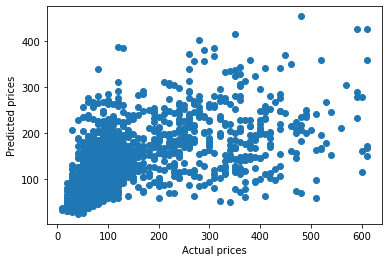

Mean squared error:  4061.1962496808783
Root mean squared error:  63.72751564027016
R-squared:  0.47505143397843264


In [50]:
# Run Random Forest Model
# Create X features set and y outcome set
X = df_filtered.drop(["Appliances"], axis=1)
y = df_filtered["Appliances"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Initiate Random Forest instance
rfr = RandomForestRegressor()

# Train model
rfr.fit(X_train, y_train)

# Predict target values for the validation set
y_pred = rfr.predict(X_val)

# Plot predicted values  against the actual values for the validation set
plt.scatter(y_val, y_pred)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

# Calculate R-squared score
r2 = r2_score(y_val, y_pred)
print("R-squared: ", r2)


Random Forest Model statistics for the test set


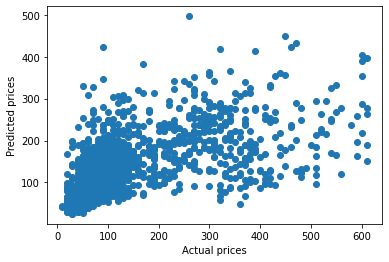

Mean squared error:  3963.4971713045697
Root mean squared error:  62.95631160816658
R-squared:  0.49122847231679134


In [51]:
# Random Forest Model is selected as the final model
# Predict target values for the test set
y_pred = rfr.predict(X_test)

print("Random Forest Model statistics for the test set")

# Plot predicted values against the actual values for the test set
plt.scatter(y_test, y_pred)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared: ", r2)


* The Random Forest Model is selected as it shows the highest R-squared value. The model gets a R-squared values of 0.49 with the test set.